# Take-home Challenge #1

The problem statement is available [here](https://github.com/metacreek/springboard/blob/master/mini-projects/relax_challenge/relax_data_science_challenge.pdf).

First, I load some libraries needed for analysis and import the data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
takehome_users = pd.read_csv('takehome_users.csv', 
                             encoding='latin-1', 
                             parse_dates=['creation_time'],
                             infer_datetime_format=True)

In [3]:
takehome_users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Here, I do some conversions, getting date strings into actual dates, and creating some True/False flags for things such as whether the `invited_by_user_id` column is populated, and whether the `last_session_creation_timestamp` column is populated.  We might want to look at those as clues to user behavior.

In [4]:
takehome_users['last_session_creation_timestamp'] = pd.to_datetime(takehome_users['last_session_creation_time'], unit='s')

Note the conversion to a "month number".  The actual number doesn't matter that much, so I do an arbitrary subtraction to get a number that looks nice.

In [5]:
takehome_users['creation_time_epoch'] = takehome_users['creation_time'].astype('int') // (86400 * 1000000000 * 30) - 500

In [6]:
takehome_users['invited_by_user'] = takehome_users['invited_by_user_id'].notna() * 1

In [7]:
takehome_users['last_session_happened'] = takehome_users['last_session_creation_timestamp'].notna() * 1

In [8]:
takehome_users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_timestamp,creation_time_epoch,invited_by_user,last_session_happened
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,39,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,34,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,26,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,28,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,24,1,1


In [9]:
takehome_user_engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [10]:
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Next, I create a 7-day rolling window and look for users with 3 or more logins within that time period.  These users will be considered **adopted** as specified in the problem statement, and I set a flag in the `adopted` column to track these users.

In [11]:
rolling_7_day_engagement = takehome_user_engagement.groupby(by='user_id').rolling('7d', on='time_stamp').count()

In [12]:
adopted_user_data = rolling_7_day_engagement[rolling_7_day_engagement['visited'] >= 3]

In [13]:
adopted_ids = set(adopted_user_data.index.get_level_values(0))

In [14]:
takehome_users['adopted'] = takehome_users.apply(lambda x: int(x['object_id'] in adopted_ids), axis=1)

Next, we look at some basic statistics.   We find that 13.35 percent of users are considered adopted.   If we look at the various creation_source possibilities, we note that signups from invites to join personal projects has the worst adoption rate.   The other methods are close to the average adoption rate, with Guest Invites and Google Auth Signups having the best adoption rate. 

In [15]:
takehome_users['adopted'].mean()

0.1335

In [16]:
takehome_users.groupby(by='creation_source').adopted.value_counts()

creation_source     adopted
GUEST_INVITE        0          1803
                    1           360
ORG_INVITE          0          3701
                    1           553
PERSONAL_PROJECTS   0          1947
                    1           164
SIGNUP              0          1794
                    1           293
SIGNUP_GOOGLE_AUTH  0          1153
                    1           232
Name: adopted, dtype: int64

In [17]:
takehome_users.groupby(by='creation_source').adopted.mean()

creation_source
GUEST_INVITE          0.166436
ORG_INVITE            0.129995
PERSONAL_PROJECTS     0.077688
SIGNUP                0.140393
SIGNUP_GOOGLE_AUTH    0.167509
Name: adopted, dtype: float64

I created a column called `invited_by_user` which indicates if the `invited_by_user_id` column was populated.  This sounds similar to what is represented by the `creation_source` column.  When we look, we see that all users where `invited_by_user` is True are either Guest or Organization Invites as we might expect.   When we examine results we may want to decide whether to consider invites overall separately from the breakdown of organization and guest invites.

In [18]:
takehome_users.groupby(by=['invited_by_user', 'creation_source']).object_id.count()

invited_by_user  creation_source   
0                PERSONAL_PROJECTS     2111
                 SIGNUP                2087
                 SIGNUP_GOOGLE_AUTH    1385
1                GUEST_INVITE          2163
                 ORG_INVITE            4254
Name: object_id, dtype: int64

Next, I do some setup so that I can use `scikit-learn` for analysis.

There are inherent problems in using a `LabelEncoder` for categorical data when there is no inherent ordering in the categories.   However, for getting a quick estimate of feature importance, it is easier to use than using the `OneHotEncoder` which would split each category value into its own feature.  The latter approach makes it harder to combine the resulting features into one true feature.   A more in-depth analysis would need to investigate this further. 

In [19]:
label_encoder = LabelEncoder()
takehome_users['creation_source_id'] = label_encoder.fit_transform(takehome_users['creation_source'])

In [20]:
takehome_users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_timestamp,creation_time_epoch,invited_by_user,last_session_happened,adopted,creation_source_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,39,1,1,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,34,1,1,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,26,1,1,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,28,1,1,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,24,1,1,0,0


Next, I am going to define a function that lets us examine the importance of different features.   This function will use a Random Forest Classifier to fit the data to predict adopted users.  I use a `RandomForestClassifier` because it can tell us which features are most important.  I also am using a set of hyperparameters to try to get the best fit.  The best model will be returned along with the feature importances.  We divide the data set into training and test data so that we can get a measure of how well our model does with independent data.   We are using accuracy as the goal for fitting.

We will call this functions with different sets of features.

In [21]:
def evaluate(takehome_users, features):
    """
    Fit user data, returning the best classifier and feature importance
    
    :param takehome_user: DataFrame with appropriate data for analysis
    :param features: list of feature columns to use in fit
    """
    X = takehome_users[features]
    y = takehome_users['adopted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)
    param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [2, 5, None],
              'min_samples_leaf': [2, 3, 5],
              'criterion': ['gini', 'entropy']
             }
    classifier = RandomForestClassifier()
    cv = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1, verbose=5)
    cv.fit(X_train, y_train)
    best_estimator = cv.best_estimator_
    print("Training Score: ", best_estimator.score(X_train, y_train))
    print("Test Score:     ", best_estimator.score(X_test, y_test))
    feature_importances = list(zip(features, best_estimator.feature_importances_))
    return best_estimator, feature_importances

In [22]:
features = ['creation_time_epoch', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user', 
            'creation_source_id']

In [23]:
best, importances = evaluate(takehome_users, features)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.4s


Training Score:  0.8664583333333333
Test Score:      0.8666666666666667


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   13.3s finished


In [24]:
importances

[('creation_time_epoch', 0.46738507538413837),
 ('opted_in_to_mailing_list', 0.005759999952127),
 ('enabled_for_marketing_drip', 0.007856435499742562),
 ('org_id', 0.33326725190442885),
 ('invited_by_user', 0.014834703815742636),
 ('creation_source_id', 0.17089653344382072)]

This shows account creation time to be the most important feature, followed by organization id.  We will plot the reltaionship between account creation time and adoption rate.

In [25]:
creation_adoption = takehome_users.groupby('creation_time_epoch').adopted.mean()

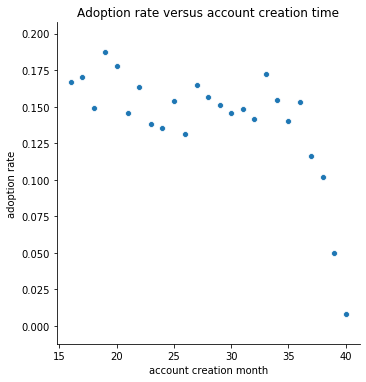

In [26]:
sns.relplot(data=creation_adoption)
plt.title("Adoption rate versus account creation time")
plt.ylabel("adoption rate")
plt.xlabel("account creation month")
plt.show()

Next, I remove account creation time and look for the next most important feature.

In [27]:
features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user', 
            'creation_source_id']

In [28]:
best, importances = evaluate(takehome_users, features)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    7.5s


Training Score:  0.8664583333333333
Test Score:      0.8666666666666667


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   12.7s finished


In [29]:
importances

[('opted_in_to_mailing_list', 0.016746478108492144),
 ('enabled_for_marketing_drip', 0.007953166996875998),
 ('org_id', 0.6066118372025409),
 ('invited_by_user', 0.05556238341461552),
 ('creation_source_id', 0.3131261342774755)]

The org_id is the next most important feature.   

In [30]:
org_adoption = takehome_users.groupby('org_id').adopted.mean()

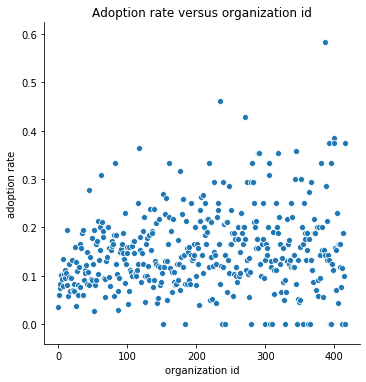

In [31]:
sns.relplot(data=org_adoption)
plt.title("Adoption rate versus organization id")
plt.xlabel("organization id")
plt.ylabel("adoption rate")
plt.show()

There is clearly a wide variation in adoption rates for different organizations, but there is no clear association with the organization id.

Finally, I remove org_id and look to see the next most important feature.

In [32]:
features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_id']

In [33]:
best, importances = evaluate(takehome_users, features)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:    6.1s


Training Score:  0.8664583333333333
Test Score:      0.8666666666666667


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    7.9s finished


In [34]:
importances

[('opted_in_to_mailing_list', 0.10888367942664108),
 ('enabled_for_marketing_drip', 0.1368732962599715),
 ('creation_source_id', 0.7542430243133874)]

For users that were invited to join via a guest or organization invite, we have the id of the individual who made the invite.  Let's take a look to see if it is important.  For this, we will only use the subset of data where we have this informtion.

In [35]:
takehome_users_with_invited_id = takehome_users[takehome_users['invited_by_user'] == 1]

In [36]:
features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id', 
            'creation_source_id']

In [37]:
best, importances = evaluate(takehome_users_with_invited_id, features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    6.6s


Training Score:  0.8577829729203195
Test Score:      0.8574766355140186


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   11.3s finished


In [38]:
importances

[('opted_in_to_mailing_list', 0.1134301028627431),
 ('enabled_for_marketing_drip', 0.08599027614838871),
 ('invited_by_user_id', 0.488489103803745),
 ('creation_source_id', 0.31209051718512315)]

This indicates that the id of the user that made the invite is a stronger signal than the type of invite.